In [1]:
# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

# Import train & test data 
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

sex and age: 37
high_BP: 47
heart_condition_detected_2017: 50
married: 15
job_status and living_area: 31
average_blood_sugar: 61
BMI: 1204
smoker_status: 10640
TreatmentA: 33217
TreatmentB: 33217
TreatmentC: 33217
TreatmentD: 33217
stroke_in_2018: 34

Total: 34872


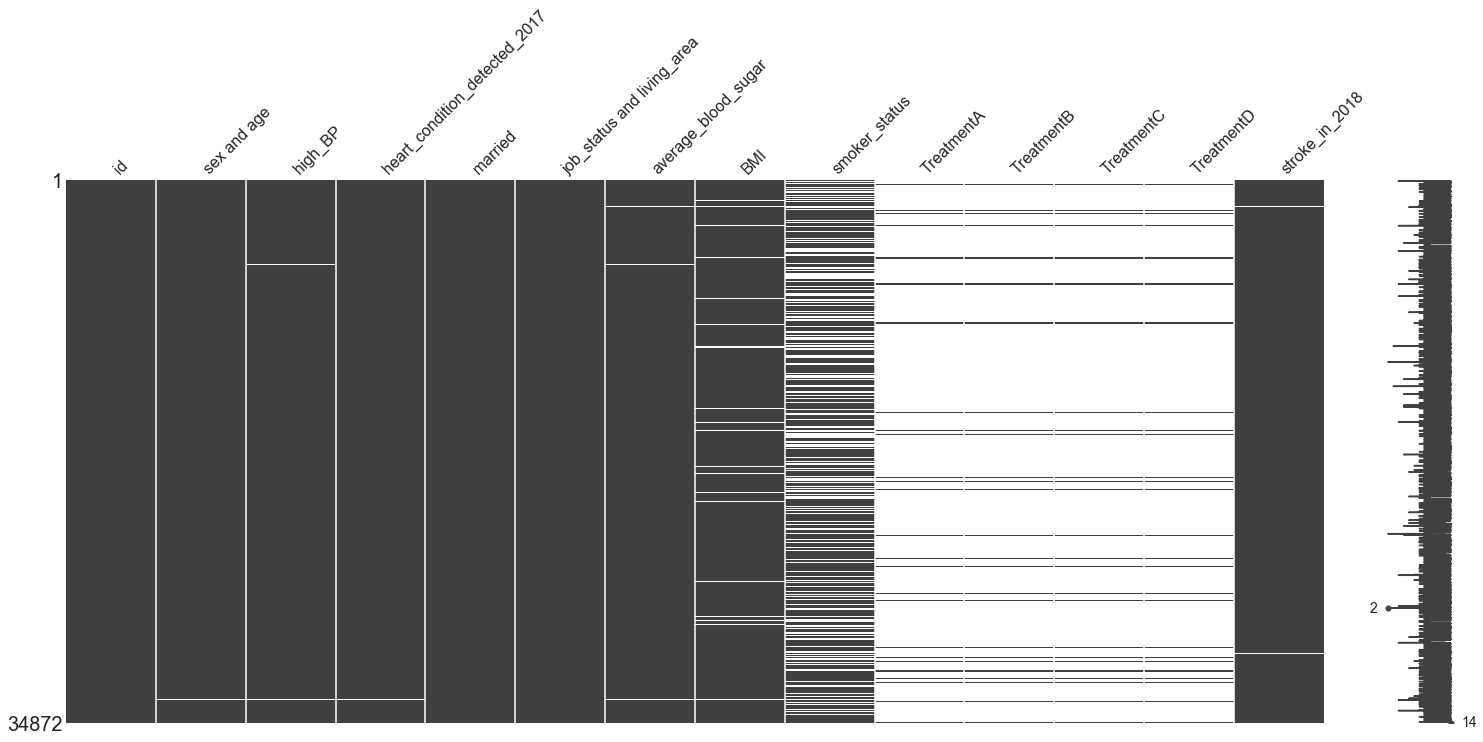

In [5]:
all_is_null = zip(train.isnull(), train.isnull().sum())
for is_null in all_is_null:
    if is_null[1] > 0:
        print(f'{is_null[0]}: {is_null[1]}')
print()
print(f'Total: {len(train)}')

missingno.matrix(train)

sex and age: 10
high_BP: 11
heart_condition_detected_2017: 5
married: 2
job_status and living_area: 10
average_blood_sugar: 11
BMI: 302
smoker_status: 2697
TreatmentA: 8302
TreatmentB: 8302
TreatmentC: 8302
TreatmentD: 8302

Total: 34872


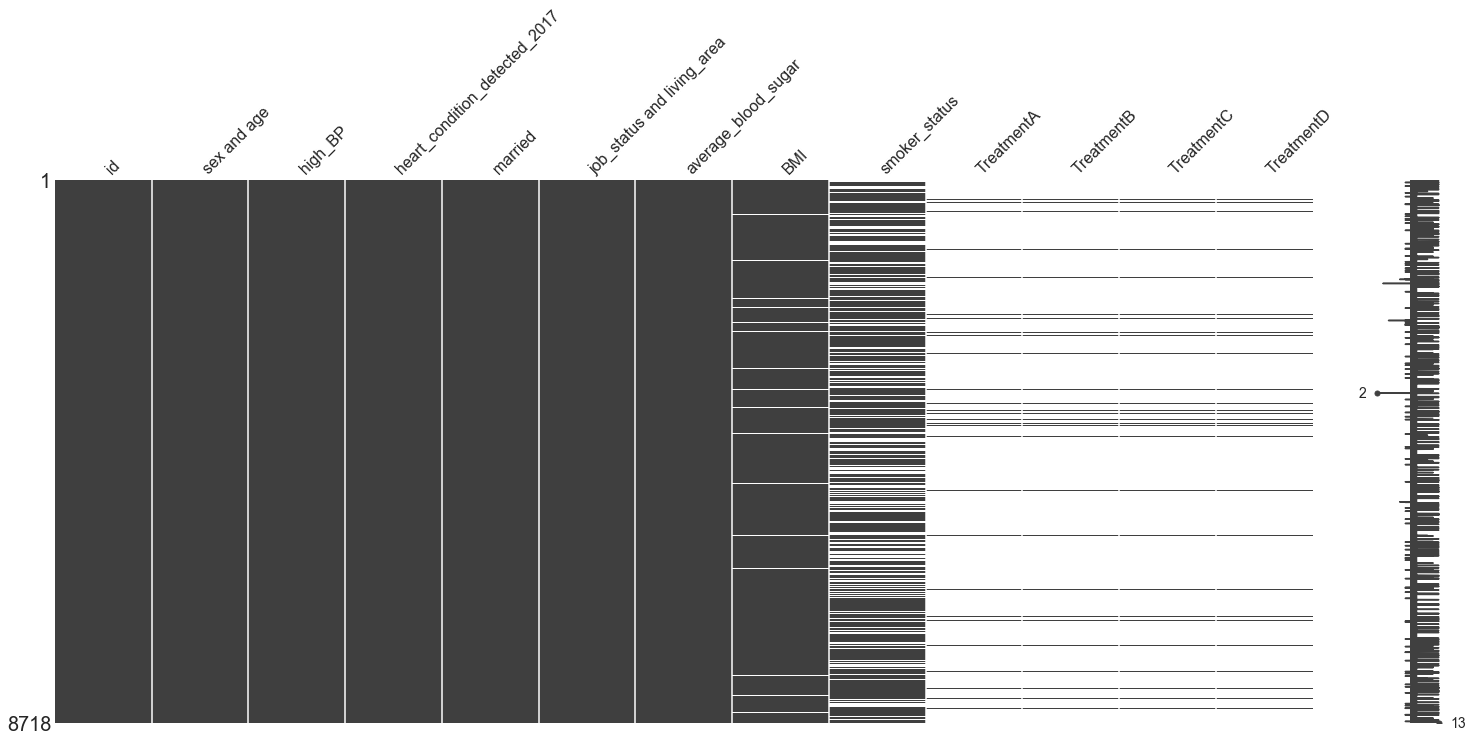

In [6]:
all_is_null = zip(test.isnull(), test.isnull().sum())
for is_null in all_is_null:
    if is_null[1] > 0:
        print(f'{is_null[0]}: {is_null[1]}')
print()
print(f'Total: {len(train)}')

missingno.matrix(test)

Training data
Total people who had strokes: 652
Fraction of people who had strokes: 0.9812848039497101

Test data
Fraction of people who had strokes: 0.98480 (approx. from submission)

0       34179
1         652
.           3
?           1
,           1
nuLL        1
N?A         1
Name: stroke_in_2018, dtype: int64


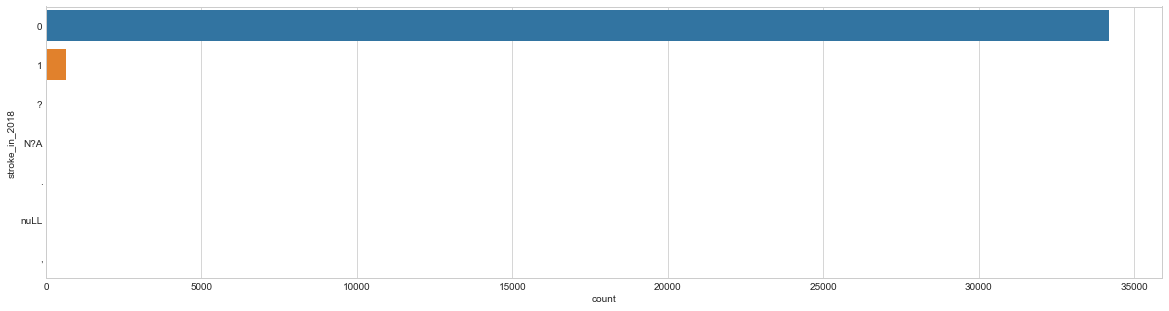

In [13]:
total_stroke = train[train['stroke_in_2018'] == '1']['stroke_in_2018'].count()
total_samples = train['stroke_in_2018'].count()
print('Training data')
print(f'Total people who had strokes: {total_stroke}')
print(f'Fraction of people who had strokes: {1 - (total_stroke / total_samples)}')
print()

print('Test data')
print(f'Fraction of people who had strokes: 0.98480 (approx. from submission)')
print()

fig = plt.figure(figsize=(20,5))
sns.countplot(y='stroke_in_2018', data=train);
print(train.stroke_in_2018.value_counts())

In [14]:
from word2number import w2n
def getGender(x):
    return 1 if x.lower() == 'm' else (0 if x.lower() == 'f' else (2 if x.lower() == 'other' else ''))

def splitAgeGender(x, ret_age=True):
    if not x or str(x) == 'nan':
        return ''
    
    parts = str(x).replace(',', ' ').split()
    age = gender = ''
    if ret_age:
        try:
            age = w2n.word_to_num(parts[0])
        except ValueError:
            try:
                age = float(parts[0])
            except ValueError:
                pass
        if not age and len(parts) > 1:
            try:
                age = w2n.word_to_num(parts[1])
            except ValueError:
                try:
                    age = float(parts[1])
                except ValueError:
                    pass
        return age
    else:
        gender = getGender(parts[0])
        if gender == '' and len(parts) > 1:
            gender = getGender(parts[1])
        return gender

def discreteAge(x):
    if not x:
        return 0
    return int(x // 5) + 1
    
# Added - Job and location
def split_job_livivng(line, job = True):
    if not line or str(line) == 'nan':
        return 'AAA'
    
    part_1, part_2 = line.split('?')[:2:]
    if job:
        if 'gov' in part_1.lower() or 'gov' in part_2.lower():
            part_1 = 'GOVERNMENT'
        elif 'pri' in part_1.lower() or 'pri' in part_2.lower():
            part_1 = 'PRIVATE'
        elif 'bus' in part_1.lower() or 'bus' in part_2.lower() or 'biz' in part_1.lower() or 'biz' in part_2.lower():
            part_1 = 'BUSINESS'
        elif 'parent' in part_1.lower() or 'parent' in part_2.lower():
            part_1 = 'PARENTAL_LEAVE'
        elif 'unemp' in part_1.lower() or 'unemp' in part_2.lower():
            part_1 = 'UNEMPLOYED'
        else:
            part_1 = 'AAA'
        return part_1

    else:    
        if 'city' in part_1.lower() or 'city' in part_2.lower():
            part_2 = 'CITY'
        elif 'remo' in part_1.lower() or 'remo' in part_2.lower():
            part_2 = 'REMOTE'        
        elif part_1 == 'c' or part_2 == 'c':
            part_2 = 'CITY'
        elif part_1 == 'r' or part_2 == 'r':
            part_2 = 'REMOTE'
        else:
            part_2 = 'AAA'
        return part_2

def getSmokeStatus(x):
    x = str(x).lower()
    x = ''.join([i for i in x if i.isalpha()])
    return 1 if 'non' in x else (2 if 'quit' in x else (3 if 'active' in x else 0))

def fixBmi(x):
    x = str(x)
    if x == 'nan' or x == '?' or x == '.':
        x = 0
        
    return float(x)

def discreteBmi(x):
    if x < 0.5:
        return 0
    elif x < 18.5:
        return 1
    elif x < 25:
        return 2
    elif x < 30:
        return 3
    elif x < 35:
        return 4
    elif x < 40:
        return 5
    return 6

def discreteBloodSugar(x):
    if x < 70:
        return 1
    elif x < 120:
        return 2
    elif x < 200:
        return 3
    elif x < 280:
        return 3
    return 4

def cleanBinary(x, flip=False):
    val = x
    try:
        val = int(x)
        if flip:
            val = 1 if val == 1 else 0
        else:
            val = 0 if val == 0 else 1
    except ValueError:
        val = ''
    return val

def checkTreated(x):
    if str(x['TreatmentA']) == 'nan':
        return 0
    return 1 if (x['TreatmentA'] == 1 or x['TreatmentB'] == 1 or x['TreatmentC'] == 1 or x['TreatmentD_2'] == 1) else 0

def bmiMean(x, m):
    if x > 0.5:
        return x
    return m

In [23]:
def createCleanedData(test_type):
    if test_type == 'test':
        old_df = test
    else:
        old_df = train
    
    new_df = pd.DataFrame(old_df)

    new_df['sex'] = old_df['sex and age'].apply(lambda x: splitAgeGender(x, False))
    new_df['age'] = old_df['sex and age'].apply(lambda x: splitAgeGender(x, True))
    
    new_df['age_2'] = old_df['age'].apply(lambda x: discreteAge(x))

    new_df['job'] = old_df['job_status and living_area'].apply(lambda x: split_job_livivng(x, True))
    new_df['location'] = old_df['job_status and living_area'].apply(lambda x: split_job_livivng(x, False))

    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()

    new_df['job_encoded'] = encoder.fit_transform(new_df['job'])
    new_df['location_encoded'] = encoder.fit_transform(new_df['location'])

    new_df['smoker_status_2'] = old_df['smoker_status'].apply(getSmokeStatus)

    new_df['BMI'] = old_df['BMI'].apply(fixBmi)
    new_df['BMI_2'] = new_df['BMI'].apply(discreteBmi)

    if 'stroke_in_2018' in new_df:
        new_df_2 = new_df[new_df['stroke_in_2018'].isin(['1', '0'])]
    else:
        new_df_2 = new_df

    new_df_2['average_blood_sugar_2'] = new_df_2['average_blood_sugar'].apply(discreteBloodSugar)
    new_df_2['high_BP_2'] = new_df_2['high_BP'].apply(cleanBinary)
    new_df_2['heart_condition_detected_2017_2'] = new_df_2['heart_condition_detected_2017'].apply(cleanBinary)
    new_df_2['married_2'] = new_df_2['married'].apply(cleanBinary)
    new_df_2['TreatmentD_2'] = new_df_2['TreatmentD'].apply(cleanBinary)
    new_df_2['treated'] = new_df_2.apply(lambda row: checkTreated(row), axis=1)

    new_df_3 = new_df_2.replace('', np.nan, regex=True)

    BMI_mean = new_df_3['BMI'].mean()
    new_df_3['BMI_3'] = new_df_3['BMI'].apply(lambda x: bmiMean(x, BMI_mean))

    new_df_3['sex'].fillna(0, inplace=True)
    new_df_3['age'].fillna(new_df_3['age'].mean(), inplace=True)
    new_df_3['high_BP_2'].fillna(0, inplace=True)
    new_df_3['heart_condition_detected_2017_2'].fillna(0, inplace=True)
    
    new_df_3['average_blood_sugar'].fillna(new_df_3['average_blood_sugar'].mean(), inplace=True)
    new_df_3['married_2'].fillna(1, inplace=True)
    new_df_3['TreatmentA'].fillna(0, inplace=True)
    new_df_3['TreatmentB'].fillna(0, inplace=True)
    new_df_3['TreatmentC'].fillna(0, inplace=True)
    new_df_3['TreatmentD_2'].fillna(0, inplace=True)

    new_df_3.to_csv(f'./Data/{test_type}_cleaned.csv')
    return new_df_3

In [24]:
train_clean = createCleanedData('train')
test_clean = createCleanedData('test')

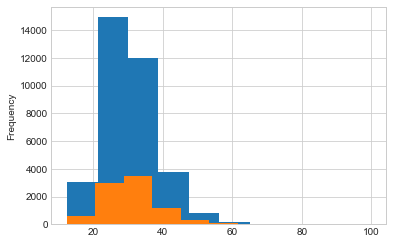

In [27]:
train_clean.BMI_3.plot.hist()
test_clean.BMI_3.plot.hist()

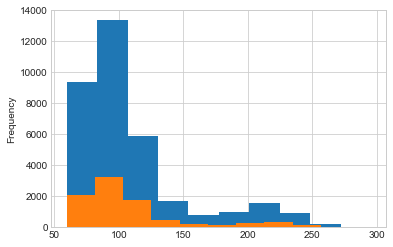

In [28]:
train_clean.average_blood_sugar.plot.hist()
test_clean.average_blood_sugar.plot.hist()

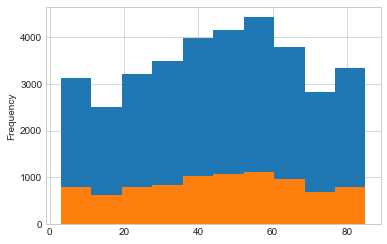

In [29]:
train_clean.age.plot.hist()
test_clean.age.plot.hist()

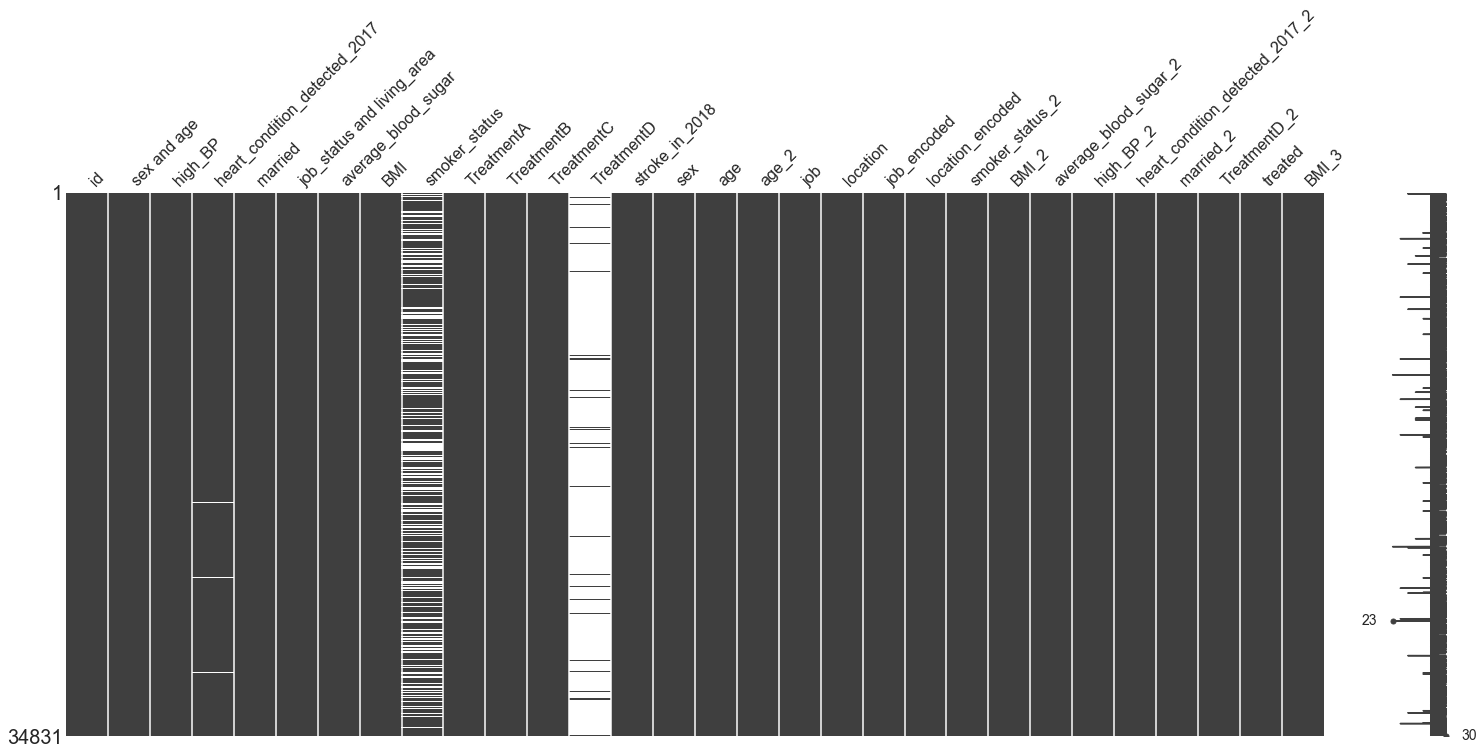

In [31]:
missingno.matrix(train_clean)

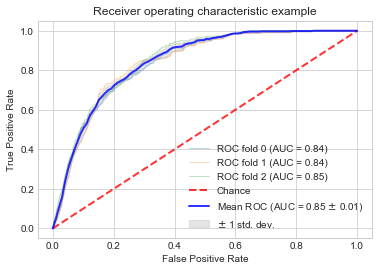

In [49]:
from sklearn import svm, datasets
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import StratifiedKFold

train_clean_2 = pd.read_csv('./Data/train_cleaned.csv')
x_train = train_clean_2[['sex', 'age', 'high_BP_2', 'heart_condition_detected_2017_2', 'married_2', 'average_blood_sugar_2', 'BMI_3', 'smoker_status_2', 'treated']].copy()
y_train = train_clean_2[['stroke_in_2018']].copy()

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=3)
classifier = LogisticRegressionCV()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(x_train, y_train):
    probas_ = classifier.fit(x_train.iloc[train], y_train.iloc[train]).predict_proba(x_train.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Logistic Done...
SVM Done...
Naive Bayes Done...
DT Done...
KNN Done...


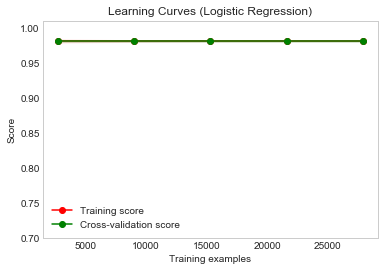

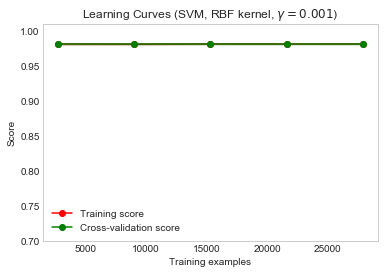

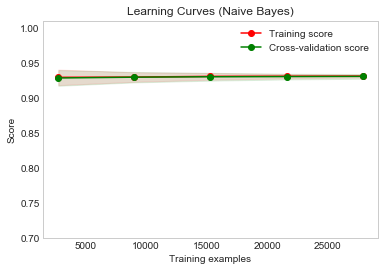

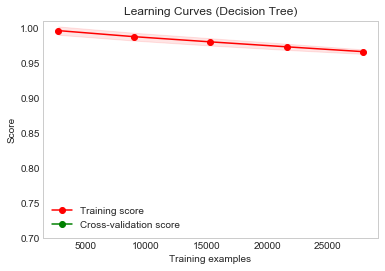

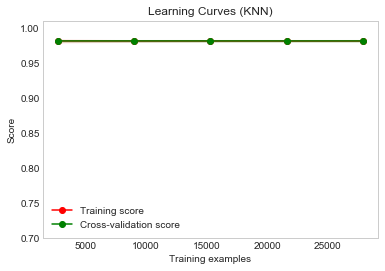

In [51]:
# Learning Curve for Bias analysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y = x_train, y_train

# Logistic
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LogisticRegressionCV(cv=5, random_state=0, multi_class='ovr')
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
print('Logistic Done...')

# SVM
title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)
print('SVM Done...')

# Naive Bayse
title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
print('Naive Bayes Done...')

# Decision Tree
title = "Learning Curves (Decision Tree)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = tree.DecisionTreeRegressor()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
print('DT Done...')


# KNN
title = "Learning Curves (KNN)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = KNeighborsClassifier(n_neighbors=10)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
print('KNN Done...')

In [52]:
# Now resample the data
import imblearn

data = pd.read_csv('./Data/train_cleaned.csv')

np.random.seed(seed=1)
mask = np.random.rand(data.shape[0]) < 0.7
train = data[mask]
test = data[~mask]

train.to_csv('./Data/train_clean_split.csv')
test.to_csv('./Data/test_clean_split.csv')

used_features = ['age', 'high_BP_2', 'average_blood_sugar', 'BMI_3', 'TreatmentA', 'TreatmentB', 'TreatmentC', 'TreatmentD_2']
#used_features = ['sex', 'age', 'high_BP_2', 'heart_condition_detected_2017_2', 'married_2', 'average_blood_sugar_2', 'BMI_3', 'smoker_status_2', 'TreatmentA', 'TreatmentB', 'TreatmentC', 'TreatmentD_2']

x_train = train[used_features].copy()
y_train = train[['stroke_in_2018']].copy()
train.describe()

Using TensorFlow backend.


,Unnamed: 0,id,average_blood_sugar,BMI,TreatmentA,TreatmentB,TreatmentC,stroke_in_2018,sex,age,...,location_encoded,smoker_status_2,BMI_2,average_blood_sugar_2,high_BP_2,heart_condition_detected_2017_2,married_2,TreatmentD_2,treated,BMI_3
count,24389.000000,24389.000000,24389.000000,24389.000000,24389.000000,24389.000000,24389.000000,24389.000000,24389.000000,24389.000000,...,24389.000000,24389.000000,24389.000000,24389.000000,24389.000000,24389.000000,24389.000000,24389.000000,24389.000000,24389.000000
mean,17444.176309,21656.621305,109.173065,29.848866,0.008692,0.014146,0.008610,0.019394,0.408750,45.272781,...,1.497519,1.175161,3.512813,2.140186,0.093362,0.047644,0.642708,0.010251,0.033663,30.887460
std,10090.457572,12536.501093,43.255927,9.514981,0.092829,0.118094,0.092394,0.137908,0.491946,22.573450,...,0.501642,1.032197,1.465911,0.550385,0.290945,0.213017,0.479212,0.100727,0.180363,7.646999
min,0.000000,3.000000,59.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.080000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.600000
25%,8656.000000,10791.000000,81.930000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000,...,1.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.700000
50%,17449.000000,21661.000000,96.250000,29.800000,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,...,1.000000,1.000000,3.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,29.870589
75%,26197.000000,32546.000000,116.750000,35.000000,0.000000,0.000000,0.000000,0.000000,1.000000,63.000000,...,2.000000,2.000000,5.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,35.000000
max,34871.000000,43399.000000,295.650000,99.900000,1.000000,1.000000,1.000000,1.000000,2.000000,85.000000,...,2.000000,3.000000,6.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,99.900000


Text(0.5,1,'No Stroke (0) vs. Stroke (1)')

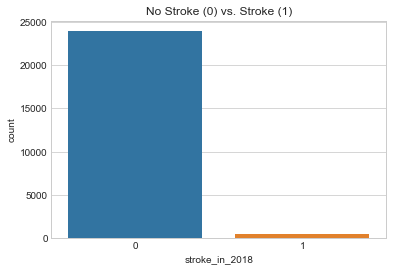

In [53]:
sns.countplot('stroke_in_2018', data = train)
plt.title('No Stroke (0) vs. Stroke (1)')

In [56]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# random oversampling
ros = RandomUnderSampler(random_state=0)
#x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

# applying SMOTE to our data and checking the class counts
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
print(f'Total size of resampled data: {len(x_resampled)}')

Total size of resampled data: 47832


In [57]:
from ModelsTest import runTests
runTests(x_resampled, y_resampled, test_type='cv', data_used=1)

      Model        |       Time       | Accuracy (train) | Accuracy (test) 
----------------------------------------------------------------------------
  Decision Tree    |      0.942       |      100.0       |      96.36      
   Gaussian NB     |      0.223       |      69.55       |      69.54      
  Multinomial NB   |      0.146       |      70.36       |      70.36      
  LogRegression    |      0.845       |       79.5       |      79.49      
Nearest Neighbors  |      2.452       |       94.2       |       91.9      


In [59]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics

x_test = test[used_features].copy()
y_test = test[['stroke_in_2018']].copy()

def run_model(algo_name):
    algos = {'lr': LogisticRegressionCV(class_weight='balanced', scoring='roc_auc', max_iter=1000), 'knn': KNeighborsClassifier(n_neighbors=15), 
             'svm': svm.SVC(), 'dt': DecisionTreeClassifier(max_depth=5, min_samples_split=3, class_weight={0:9, 1:7})}
    algo = algos[algo_name]
    algo.fit(x_resampled, y_resampled)
    pred_train_lr = algo.predict(x_resampled)
    print('Accuracy for train: ' + str(round(metrics.accuracy_score(y_resampled, pred_train_lr) * 100, 2)))
    print('Confusion matrix for train:')
    print(metrics.confusion_matrix(y_resampled, pred_train_lr))
    print()

    pred_test_lr = algo.predict(x_test)
    print('Accuracy for test: ' + str(round(metrics.accuracy_score(y_test, pred_test_lr) * 100, 2)))
    print('Confusion matrix for test:')
    print(metrics.confusion_matrix(y_test, pred_test_lr))
    print('F1 score for test: ' + str(metrics.f1_score(y_test, pred_test_lr, average='binary')))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test_lr)
    print('AUC score for test: ' + str(metrics.auc(fpr, tpr)))
    print()
    return algo

print('Logistic regression')
lr_fit = run_model('lr')
#print('K-Nearest Neighbors')
#run_model('knn')
#print('SVM')
#run_model('svm')
print('Decisition Tree')
dt_fit = run_model('dt')

Logistic regression
Accuracy for train: 79.51
Confusion matrix for train:
[[18305  5611]
 [ 4191 19725]]

Accuracy for test: 76.27
Confusion matrix for test:
[[7829 2434]
 [  44  135]]
F1 score for test: 0.09825327510917031
AUC score for test: 0.7585136605596826

Decisition Tree
Accuracy for train: 83.59
Confusion matrix for train:
[[19713  4203]
 [ 3647 20269]]

Accuracy for test: 82.28
Confusion matrix for test:
[[8487 1776]
 [  74  105]]
F1 score for test: 0.10194174757281553
AUC score for test: 0.7067716813176583



In [61]:
import xgboost as xgb

xgb2 = xgb.XGBClassifier(
 learning_rate =0.5,
 n_estimators=100,
 max_depth=8,
 min_child_weight=3,
 gamma=5,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=2,
 seed=27)

train_model7 = xgb2.fit(x_resampled, y_resampled)
pred7 = train_model7.predict(x_test.to_numpy())
print("Accuracy for model XGBoost train: %.2f" % (metrics.accuracy_score(y_test, pred7) * 100))
print(metrics.confusion_matrix(y_test, pred7))
print('F1 Score for XGBoost test: ' + str(metrics.f1_score(y_test, pred7, average='binary')))
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred7)
print('AUC score for XGBoost test: ' + str(metrics.auc(fpr, tpr)))

Accuracy for model XGBoost train: 97.00
[[10105   158]
 [  155    24]]
F1 Score for XGBoost test: 0.1329639889196676
AUC score for XGBoost test: 0.5593415518239029


In [62]:
test_data = pd.read_csv('./Data/test_cleaned.csv')
x_test_final = test_data[used_features].copy()

pred_f = lr_fit.predict(x_test_final.to_numpy())
print(pred_f.mean())

0.2384721266345492


In [63]:
output = test_data[['id']]
output['stroke_in_2018'] = pd.DataFrame(pred_f)

In [64]:
print(output)
output.to_csv('./Data/final.csv')

         id  stroke_in_2018
0     33327               0
1       839               0
2     11127               0
3     20768               0
4     37774               0
5      4283               1
6     13832               1
7      4579               0
8     26781               1
9     17196               0
10     2514               0
11    19277               1
12    17398               0
13    31096               0
14    20650               0
15     3184               0
16    25947               1
17     5128               1
18    23326               0
19    30751               0
20     2813               0
21    15246               1
22     2554               0
23    11821               0
24    36075               0
25    22637               0
26    30739               0
27     5329               0
28    41161               0
29    30743               0
...     ...             ...
8688  14277               0
8689  21603               0
8690  14473               0
8691  22513         